In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
import itertools
import matplotlib.patches as mpatches

# 0. Load location and groupings information

In [7]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_222_samples_info.tsv'
file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['sample_ID', 'Country', 'Year', 'group-Lkadj', 
                                         'Management units - based on DNA', 'Post_dupe_depth',
                                         'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type']]
INFO.rename(columns={'sample_ID':'sample', 
                     'Country':'country', 
                     'Year':'year',
                     'group-Lkadj': 'group',
                     'Management units - based on DNA': 'MU',
                     'Post_dupe_depth':'depth',
                     'Exclude-all_GL_ROH_analyses': 'exclude',
                     'Sequencing_source-type': 'batch'}, inplace=True)

In [4]:
countries_order = ['Indonesia', 'Solomon_Islands', 'Malaysia', 'Papua_New_Guinea', 'Mexico', 'Virgin_Islands',
                   'French_Guiana', 'Suriname', 'Costa_Rica', 'Ghana', 'Gabon', 'South_Africa', 'Florida']

# 1. Genetic load analysis

In [8]:
## Read summary file with total number of variants by impact
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_222/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location info to each sample
df = df[df['state'] != 'hom_ref']
df_all = pd.merge(df, INFO, on='sample')
df_all['exclude'] = df_all['exclude'].fillna('include')

## 1.1. Plot total number of variants by impact
### NB: each impact can additionally be MODIFIER (snpEff can annotate a SNP as both HIGH and MODIFIER) => MODIFIER here are variants that are annotated ONLY as modifier and no other class! 

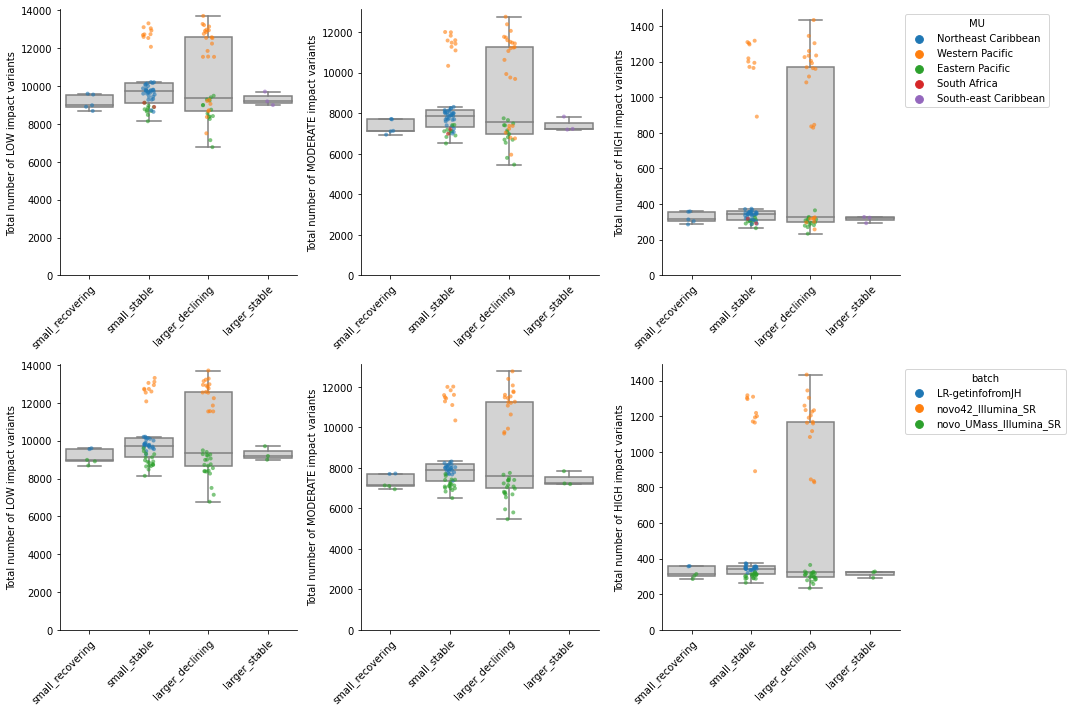

In [12]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'country', 'year', 'group', 'exclude', 'batch']).sum().reset_index()

# Exclude 'MODIFIER' variants
grouped_df = grouped_df[grouped_df['impact'] != 'MODIFIER']
impacts = set(grouped_df['impact'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

groups = ['MU', 'batch']

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]

        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='number', hue=group, alpha=0.6, s=4)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact variants')
        axi.set_xlabel('')
        axi.set_ylim(0, None)
        
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [104]:
dfi[dfi['number']>10000]

,sample,impact,MU,country,year,group,exclude,number,depth
49,96240,LOW,Northeast Caribbean,USA,2010.0,small_stable,include,10216,22.85620
53,96245,LOW,Northeast Caribbean,USA,2010.0,small_stable,include,10056,28.58220
57,96246,LOW,Northeast Caribbean,USA,2010.0,small_stable,include,10164,24.57880
61,96247,LOW,Northeast Caribbean,USA,2010.0,small_stable,include,10144,27.89200
65,96251,LOW,Northeast Caribbean,USA,2010.0,small_stable,include,10208,24.30560
69,96252,LOW,Northeast Caribbean,USA,2010.0,small_stable,include,10105,25.82040
85,96543,LOW,Northeast Caribbean,USA,2010.0,small_stable,include,10011,28.00600
105,Z026452,LOW,Western Pacific,PAPUA NEW GUINEA,2001.0,larger_declining,include,12586,16.89076
109,Z026454,LOW,Western Pacific,PAPUA NEW GUINEA,2001.0,larger_declining,include,12552,16.20296
113,Z026455,LOW,Western Pacific,PAPUA NEW GUINEA,2001.0,larger_declining,include,12543,17.17628


## 1.2. Plot fraction of variants by impact

In [63]:
G = grouped_df.groupby(['sample']).sum().reset_index()[['sample', 'number']]
G.rename({'number': 'total'}, axis='columns', inplace=True)

merged_df = pd.merge(grouped_df, G, on='sample')
merged_df['fraction'] = merged_df['number'] / merged_df['total'] * 100
merged_df.head(3)

,sample,impact,MU,country,group,exclude,number,year,depth,total,fraction
0,23560,HIGH,Northeast Caribbean,USA,small_recovering,include,359,4000.0,25.1526,1611513,0.022277
1,23560,LOW,Northeast Caribbean,USA,small_recovering,include,9557,4000.0,25.1526,1611513,0.593045
2,23560,MODERATE,Northeast Caribbean,USA,small_recovering,include,7720,4000.0,25.1526,1611513,0.479053


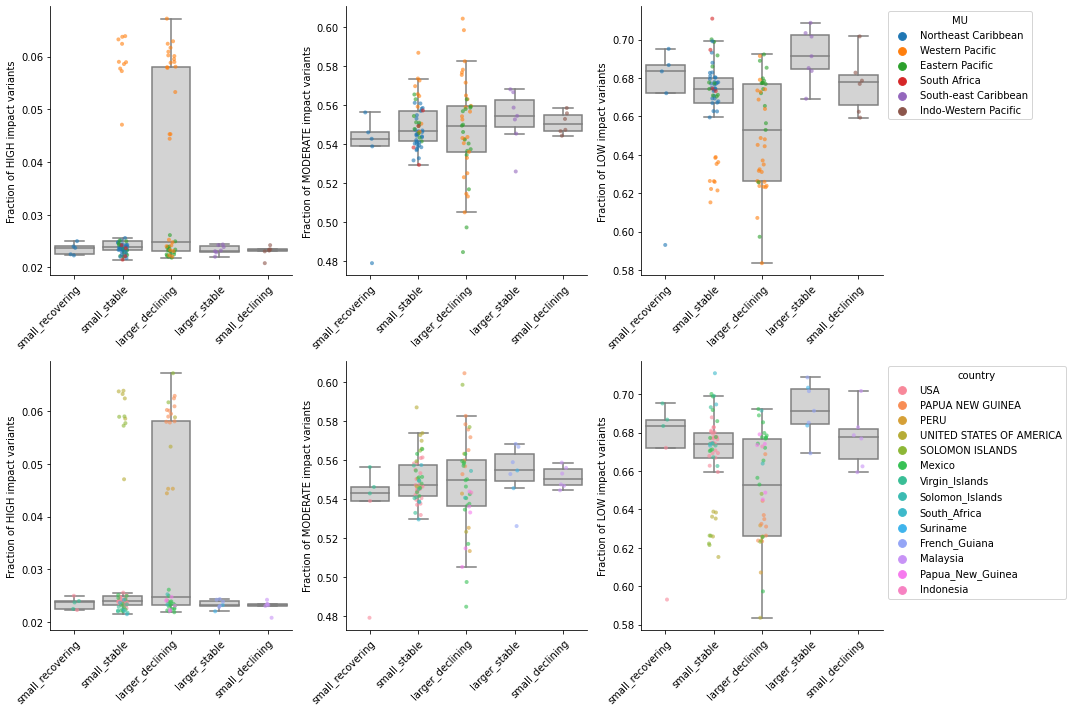

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

groups = ['MU', 'country']

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = merged_df[merged_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]

        sns.boxplot(ax=axi, data=dfi, x='group', y='fraction', showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='fraction', hue=group, alpha=0.6, s=4)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Fraction of {impact} impact variants')
        axi.set_xlabel('')


        
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## 1.3. Plot homozygotes and heterozygotes by impact
### NB: all homozygotes are alt alleles! never 0/0, only 1/1, 1|1, and rarely 2/2, 3/3, ... etc for indels

In [10]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_out/all_samples.hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

,sample,impact,state,number,country,year,depth,groupping
0,dc_100028_bb_noq,HIGH,hom,2074,Mexico,2016,14.38,recovering
1,dc_100028_bb_noq,MODERATE,hom,2524,Mexico,2016,14.38,recovering
2,dc_100028_bb_noq,LOW,hom,4073,Mexico,2016,14.38,recovering


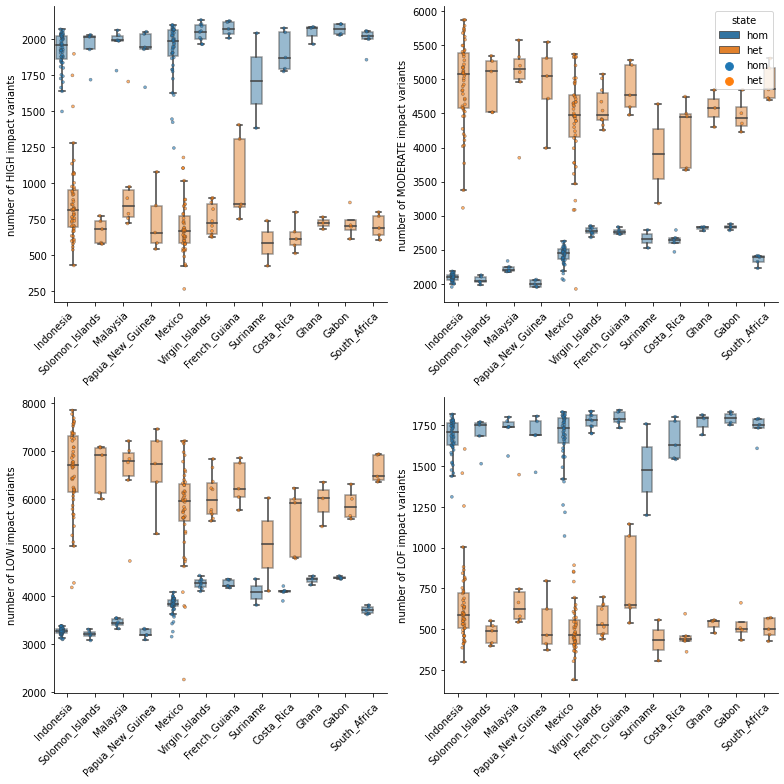

In [53]:
impacts = list(set(df_all['impact']))
fig, axes = plt.subplots(2, 2, figsize = (11, 11))

for i in range(len(impacts)):
    j = i % 2
    k = i // 2
    axi = axes[j][k]
    impact = impacts[i]
    dfi = df_all[df_all['impact'] == impact]
    
    sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                showfliers=False, boxprops=dict(alpha=0.5))
    sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                  alpha=0.6, s=3, dodge=True, linewidth=0.5)
    
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_ylabel('number of {} impact variants'.format(impact))
    axi.set_xlabel('')
    if i != 2:
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### Since the majority of HIGH impact variants are LOF (>70%), classes HIGH and LOF are almost equivalent. Leave only LOF

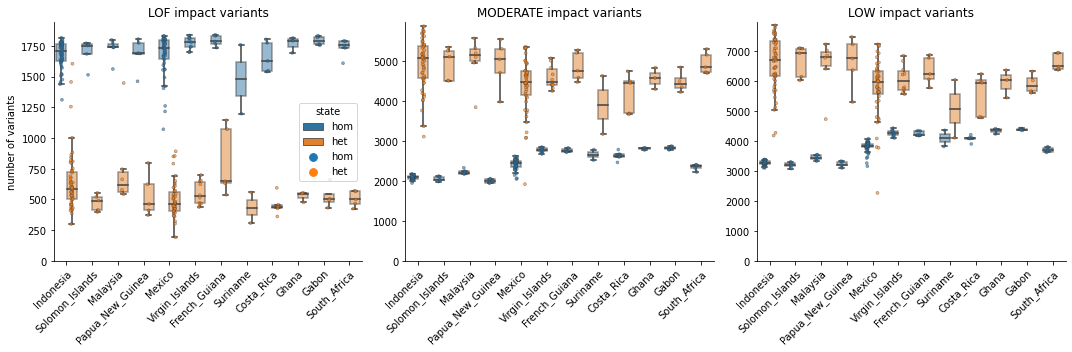

In [54]:
impacts = ['LOF', 'MODERATE', 'LOW']
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i in range(len(impacts)):
    axi = axes[i]
    impact = impacts[i]
    dfi = df_all[df_all['impact'] == impact]
    
    sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                showfliers=False, boxprops=dict(alpha=0.5))
    sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                  alpha=0.6, s=3, dodge=True, linewidth=0.5)
    
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('{} impact variants'.format(impact))
    axi.set_xlabel('')
    axi.set_ylim(0, max(dfi['number']) + 100)
    if i == 0:
        axi.set_ylabel('number of variants')
    else:
        axi.set_ylabel('')
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### Compare directly between number of variants by impact

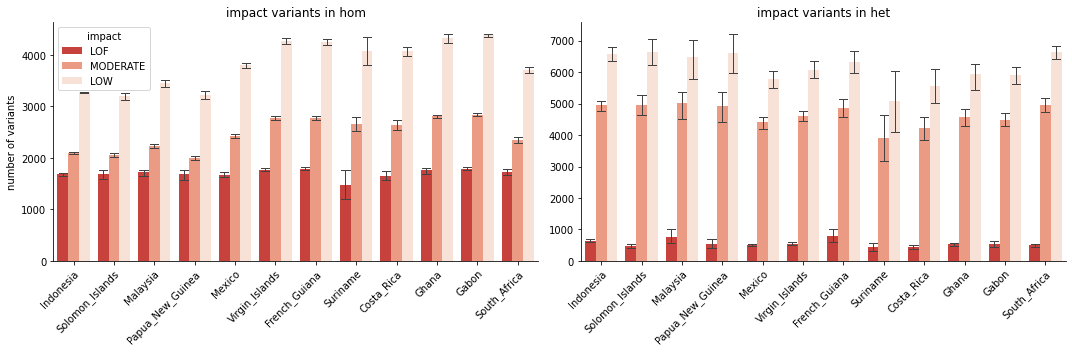

In [112]:
states = ['hom', 'het']
p = sns.color_palette(['#de2d26', '#fc9272', '#fee0d2'])

fig, axes = plt.subplots(1, 2, figsize = (15, 5))

for i in range(len(states)):
    axi = axes[i]
    state = states[i]
    dfi = df_all[(df_all['state'] == state) & (df_all['impact'] != 'HIGH')]
    
    hue_order=['LOF', 'MODERATE', 'LOW']
    sns.barplot(ax=axi, data=dfi, x='country', y='number', hue='impact', order=countries_order, 
                hue_order=hue_order, palette=p, errwidth=1, capsize=0.2)
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('impact variants in {}'.format(state))
    axi.set_xlabel('')
    if i == 0:
        axi.set_ylabel('number of variants')
    else:
        axi.set_ylabel('')
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.4. Separate each impact class into SNPs and indels

In [53]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_out/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df = df[df['state'] != 'hom_ref']

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

,sample,impact,state,number,variant,country,year,group,depth
0,dc_100028_bb_noq,HIGH,hom,104,snps,Mexico,2016,small_recovering,14.38
1,dc_100028_bb_noq,HIGH,hom,2025,indels,Mexico,2016,small_recovering,14.38
2,dc_100028_bb_noq,MODERATE,hom,2470,snps,Mexico,2016,small_recovering,14.38


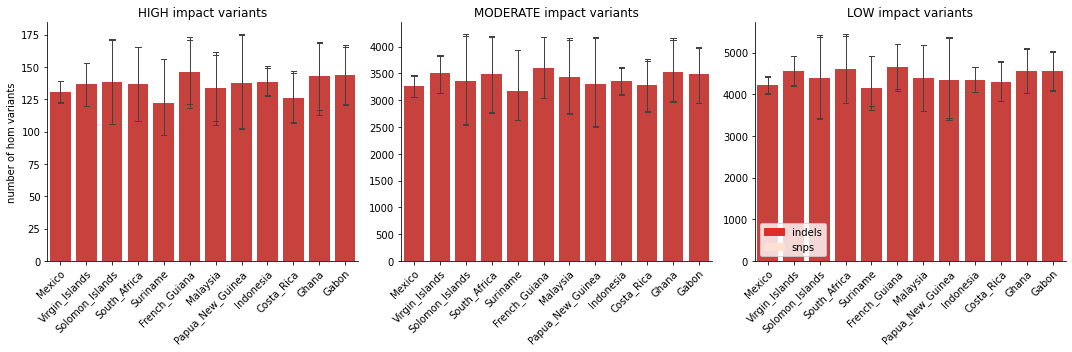

In [46]:
states = ['hom', 'het']
state = 'hom'

variant = 'indels'
df_var = df_all
c_all = '#fee0d2'
c_var = '#de2d26'

impacts = ['HIGH', 'MODERATE', 'LOW']
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i in range(len(impacts)):
    axi = axes[i]
    impact = impacts[i]
    dfi = df_var[(df_var['impact'] == impact) & (df_var['variant'] == var)]
    dfi_var = df_var[(df_var['impact'] == impact) & (df_var['variant'] == var)]
    
    sns.barplot(ax=axi, data=dfi, x='country', y='number', color=c_all, errwidth=1, capsize=0.2)
    sns.barplot(ax=axi, data=dfi_var, x='country', y='number', color=c_var, errwidth=1, capsize=0.2)
    
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('{} impact variants'.format(impact))
    axi.set_xlabel('')
    if i == 0:
        axi.set_ylabel('number of {} variants'.format(state))
    else:
        axi.set_ylabel('')
    
# add custom legend
red_patch = mpatches.Patch(color=c_var, label='indels')
pink_patch = mpatches.Patch(color=c_all, label='snps')
plt.legend(handles=[red_patch, pink_patch])

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.5. Separate variants by impact and by type: snp or indel

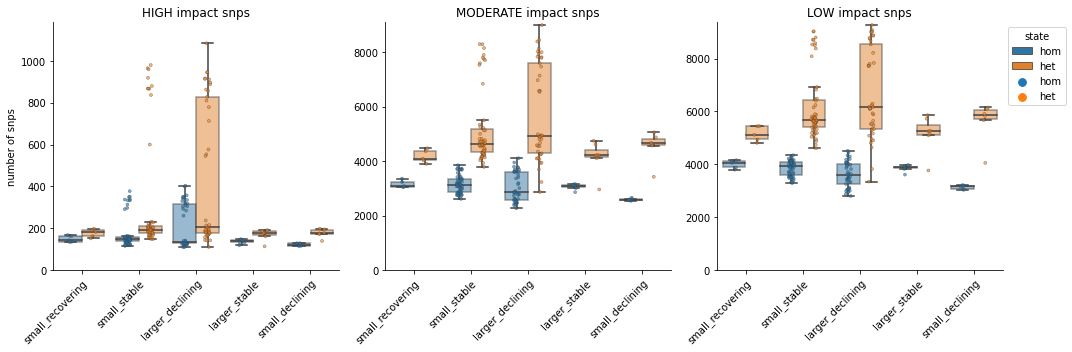

In [78]:
impacts = ['HIGH', 'MODERATE', 'LOW']
variants = ['snps']

fig, axes = plt.subplots(1, 3, figsize = (15, 5))
pal = sns.color_palette('Set2')

for i in range(len(impacts)):
    for j in range(len(variants)):
        
        axi = axes[i]
        impact = impacts[i]
        variant = variants[j]
        dfi = df_all[(df_all['variant'] ==  variant) & (df_all['impact'] ==  impact)]
        dfi = dfi[dfi['exclude'] == 'include']

#         sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
#                     showfliers=False, boxprops=dict(alpha=0.5))
#         sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
#                      alpha=0.6, s=3, dodge=True, linewidth=0.5)
        sns.boxplot(ax=axi, data=dfi, x='group', y='number', hue='state',
                    showfliers=False, boxprops=dict(alpha=0.5))
        sns.stripplot(ax=axi, data=dfi, x='group', y='number', hue='state', 
                     alpha=0.6, s=3, dodge=True, linewidth=0.5)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('{} impact {}'.format(impact, variant))
        axi.set_xlabel('')
        axi.set_ylim(0, max(dfi['number']) + 100)
        if i == 0:
            axi.set_ylabel('number of {}'.format(variant))
        else:
            axi.set_ylabel('')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.6. Plot fraction of homozygots per impact: snpEff

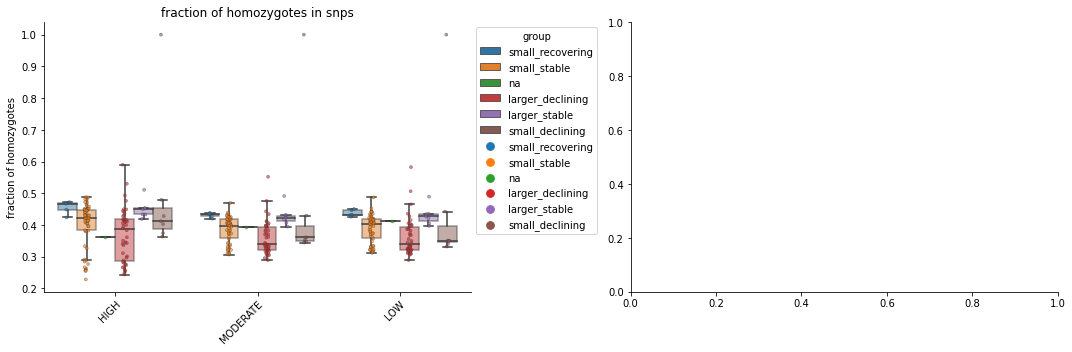

In [80]:
totals = df_all.groupby(["sample", "impact", "variant", "country"])["number"].transform("sum")
df_all["fraction"] = df_all["number"] / totals

impacts = ['HIGH', 'MODERATE', 'LOW']
variants = ['snps']
state = 'hom'

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
pal = sns.color_palette('Set2')

for j in range(len(variants)):
    axi = axes[j]
    variant = variants[j]
    dfi = df_all[(df_all['variant'] == variant) & (df_all['state'] == state) & (df_all['impact'].isin(impacts))]
    dfi = dfi[dfi['group'] != 'exclude']
    
#     sns.boxplot(ax=axi, data=dfi, x='country', y='fraction', hue='impact', order=countries_order, 
#                 showfliers=False, boxprops=dict(alpha=0.5))
#     sns.stripplot(ax=axi, data=dfi, x='country', y='fraction', hue='impact', order=countries_order, 
#                  alpha=0.6, s=3, dodge=True, linewidth=0.5)
#     sns.boxplot(ax=axi, data=dfi, x='group', y='fraction', hue='impact', 
#                 showfliers=False, boxprops=dict(alpha=0.5))
#     sns.stripplot(ax=axi, data=dfi, x='group', y='fraction', hue='impact', 
#                  alpha=0.6, s=3, dodge=True, linewidth=0.5)
    sns.boxplot(ax=axi, data=dfi, x='impact', y='fraction', hue='group', 
                showfliers=False, boxprops=dict(alpha=0.5))
    sns.stripplot(ax=axi, data=dfi, x='impact', y='fraction', hue='group', 
                 alpha=0.6, s=3, dodge=True, linewidth=0.5)

    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('fraction of homozygotes in {}'.format(variant))
    axi.set_xlabel('')
    if j == 0:
#         axi.set_ylim(0.2, 0.6)
        axi.set_ylabel('fraction of homozygotes')
        axi.get_legend().set_visible(False)
    else:
        axi.set_ylim(0, 1)
        axi.set_ylabel('')
    if i != 2:
        axi.get_legend().set_visible(False)
    else:
        sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
        
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.7. To check distnace to ref, plot both 0/0 (ref) and 1/1 (alt) homozygotes

In [115]:
## Read summary file with total number of variants by impact
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_out/all_samples.hom_het_by_impact.ref_alt.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

,sample,impact,state,number,country,year,depth
0,dc_100028_bb_noq,HIGH,hom_ref,27681,Mexico,2016,14.38
1,dc_100028_bb_noq,MODERATE,hom_ref,41419,Mexico,2016,14.38
2,dc_100028_bb_noq,LOW,hom_ref,37742,Mexico,2016,14.38


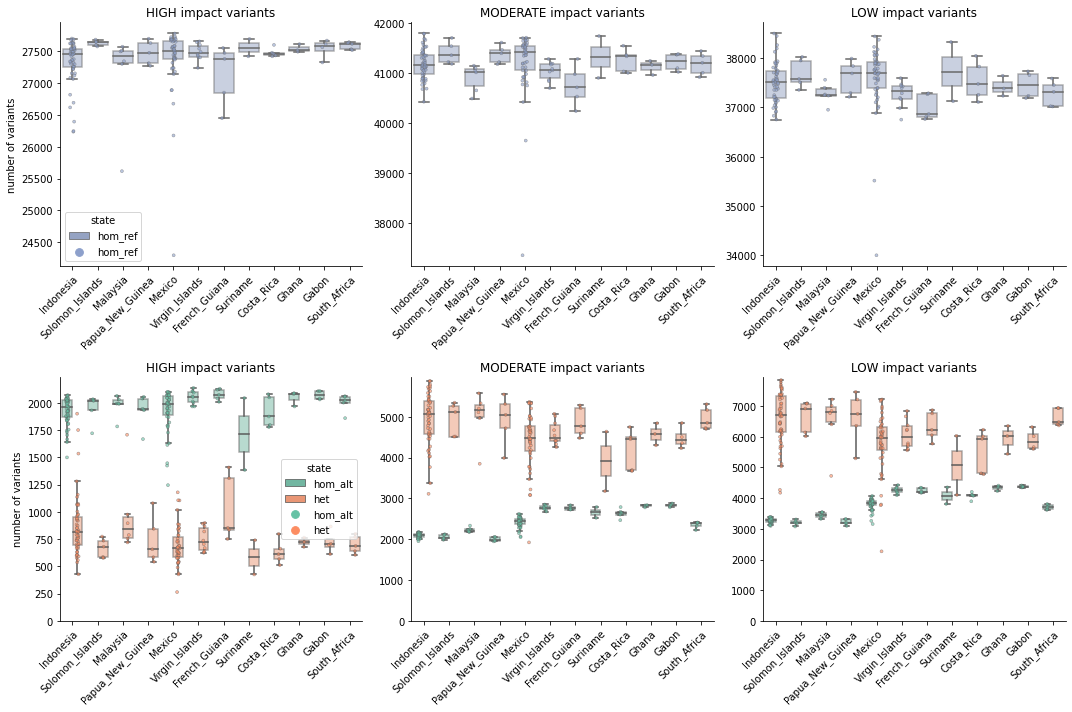

In [116]:
impacts = ['HIGH', 'MODERATE', 'LOW']
fig, axes = plt.subplots(2, 3, figsize = (15, 10))
pal = sns.color_palette('Set2')

for i in range(len(impacts)):
    impact = impacts[i]
    for j in range(2):
        if j == 0:
            ## homozygotes ref
            p = pal[2:3]
            axi = axes[j][i]
            dfi = df_all[(df_all['impact'] == impact) & (df_all['state'] == 'hom_ref')]
        else:
            ## homozygotes alt and heterogygotes
            p = pal[:2]
            axi = axes[j][i]
            dfi = df_all[(df_all['impact'] == impact) & (df_all['state'] != 'hom_ref')]

        sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                    palette=p, showfliers=False, boxprops=dict(alpha=0.5))
        sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                      palette=p, alpha=0.6, s=3, dodge=True, linewidth=0.5)


        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('{} impact variants'.format(impact))
        axi.set_xlabel('')
        if j != 0:
            axi.set_ylim(0, max(dfi['number']) + 100)
        if i == 0:
            axi.set_ylabel('number of variants')
        else:
            axi.set_ylabel('')
            axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.8 ANNOVAR annotation!

In [85]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'ANNOVAR_222/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df = df[df['state'] != 'hom_ref']

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all['exclude'] = df_all['exclude'].fillna('include')
df_all.head(3)

,sample,impact,state,number,variant,country,year,group,MU,depth,exclude
0,23560,HIGH,hom,32,snps,USA,2000.0,small_recovering,Northeast Caribbean,12.5763,include
1,23560,MODERATE,hom,2985,snps,USA,2000.0,small_recovering,Northeast Caribbean,12.5763,include
2,23560,LOW,hom,5761,snps,USA,2000.0,small_recovering,Northeast Caribbean,12.5763,include


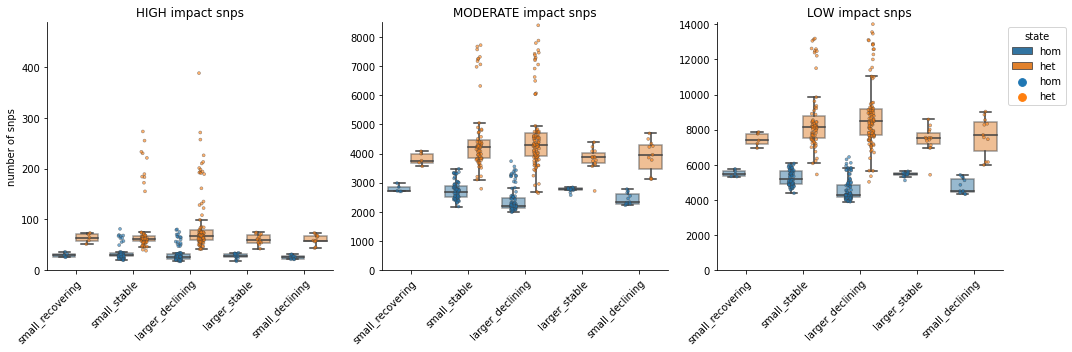

In [86]:
impacts = ['HIGH', 'MODERATE', 'LOW']
variants = ['snps']

fig, axes = plt.subplots(1, 3, figsize = (15, 5))
pal = sns.color_palette('Set2')

for i in range(len(impacts)):
    for j in range(len(variants)):
        
        axi = axes[i]
        impact = impacts[i]
        variant = variants[j]
        dfi = df_all[(df_all['variant'] ==  variant) & (df_all['impact'] ==  impact)]
        dfi = dfi[dfi['exclude'] == 'include']

        sns.boxplot(ax=axi, data=dfi, x='group', y='number', hue='state',
                    showfliers=False, boxprops=dict(alpha=0.5))
        sns.stripplot(ax=axi, data=dfi, x='group', y='number', hue='state', 
                     alpha=0.6, s=3, dodge=True, linewidth=0.5)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('{} impact {}'.format(impact, variant))
        axi.set_xlabel('')
        axi.set_ylim(0, max(dfi['number']) + 100)
        if i == 0:
            axi.set_ylabel('number of {}'.format(variant))
        else:
            axi.set_ylabel('')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.9. Plot fraction of homozygots per impact: ANNOVAR

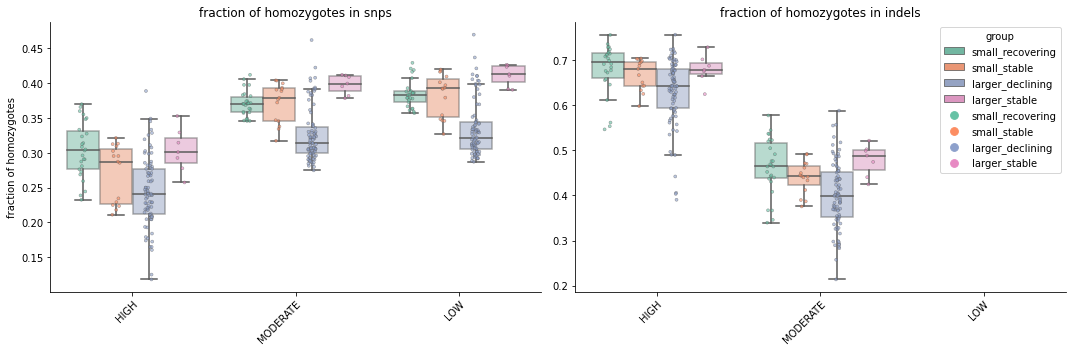

In [52]:
totals = df_all.groupby(["sample", "impact", "variant", "country"])["number"].transform("sum")
df_all["fraction"] = df_all["number"] / totals

impacts = ['HIGH', 'MODERATE', 'LOW']
variants = ['snps', 'indels']
state = 'hom'

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
pal = sns.color_palette('Set2')

for j in range(len(variants)):
    axi = axes[j]
    variant = variants[j]
    dfi = df_all[(df_all['variant'] == variant) & (df_all['state'] == state) & (df_all['impact'].isin(impacts))]
    dfi = dfi[dfi['group'] != 'exclude']
    
#     sns.boxplot(ax=axi, data=dfi, x='country', y='fraction', hue='impact', order=countries_order, 
#                 showfliers=False, boxprops=dict(alpha=0.5))
#     sns.stripplot(ax=axi, data=dfi, x='country', y='fraction', hue='impact', order=countries_order, 
#                  alpha=0.6, s=3, dodge=True, linewidth=0.5)
    sns.boxplot(ax=axi, data=dfi, x='impact', y='fraction', hue='group', 
                showfliers=False, boxprops=dict(alpha=0.5))
    sns.stripplot(ax=axi, data=dfi, x='impact', y='fraction', hue='group', 
                 alpha=0.6, s=3, dodge=True, linewidth=0.5)
    
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('fraction of homozygotes in {}'.format(variant))
    axi.set_xlabel('')
#     axi.set_ylim(0, 0.8)
    if j == 0:
        axi.set_ylabel('fraction of homozygotes')
        axi.get_legend().set_visible(False)
    else:
        axi.set_ylabel('')
        
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# 2. Temporal analysis. Mexico, Indonesia, and US Virgin Islands samples

## 2.1. Plot number of variants for 3 (Mexico), 6 (Indonesia), and 7 (US Virgin Islands)  timepoints

In [21]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_out/all_samples.hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

,sample,impact,state,number,country,year,depth,grouping
0,dc_100028_bb_noq,HIGH,hom,2074,Mexico,2016,14.38,small_recovering
1,dc_100028_bb_noq,MODERATE,hom,2524,Mexico,2016,14.38,small_recovering
2,dc_100028_bb_noq,LOW,hom,4073,Mexico,2016,14.38,small_recovering


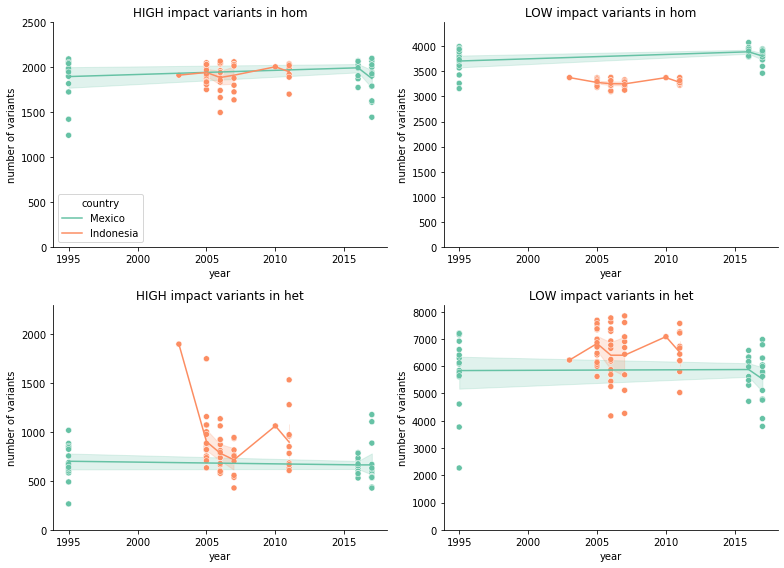

In [22]:
countries = ['Indonesia', 'Mexico', 'Virgin_Islands']
df_temporal = df_all[df_all['country'].isin(countries)].dropna()
df_temporal['year'] = pd.to_numeric(df_temporal['year'])

impacts = ['HIGH', 'LOW']
states = ['hom', 'het']

sns.set_palette('Set2')
fig, axes = plt.subplots(2, 2, figsize = (11, 8))


for i in range(4):
    j = i % 2
    k = i // 2
    axi = axes[j][k]
    impact = impacts[k]
    state = states[j]
    dfi = df_temporal[(df_temporal['impact'] == impact) & (df_temporal['state'] == state)]
    
    sns.lineplot(ax=axi, data=dfi, x='year', y='number', hue='country', marker='', ci=95)
    sns.scatterplot(ax=axi, data=dfi, x='year', y='number', hue='country', legend=False, markers=True)

    axi.set_ylim(0, max(dfi['number']) + 400)
    axi.set_title('{} impact variants in {}'.format(impact, state))
    axi.set_ylabel('number of variants')
    if i != 0:
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# 3. ROH analysis

## 3.1. ROH analysis with PLINK

In [17]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'ROH_out/all_samples_binned_ROH.tsv'
file_data = glob(dir_path + file_name)[0]
df_roh = pd.read_csv(file_data, sep='\t')
df_roh['L_total'] = df_roh['L_less100'] + df_roh['L_100_500'] + df_roh['L_500_1000'] + df_roh['L_more1000']
df_roh['L_less1000'] = df_roh['L_total'] - df_roh['L_more1000']
df_roh['L_less500'] = df_roh['L_less1000'] - df_roh['L_500_1000']
df_roh['L_ave'] = df_roh['L_total'] / df_roh['number_ROH']

## Assign location to each sample
df_all_roh = pd.merge(df_roh, INFO, on='sample')
df_all_roh.head(3)

,sample,round,number_ROH,L_less100,L_100_500,L_500_1000,L_more1000,L_total,L_less1000,L_less500,L_ave,country,year,group,depth
0,dc_100028_bb_noq,from_Lisa_window_10,8426,307695.696,740082.028,57913.185,3379.193,1109070.102,1105690.909,1047777.724,131.624745,Mexico,2016,small_recovering,14.38
1,dc_100028_bb_noq,from_Lisa_window_20,7863,294898.443,657200.359,35311.972,1070.753,988481.527,987410.774,952098.802,125.713026,Mexico,2016,small_recovering,14.38
2,dc_100028_bb_noq,from_Lisa_window_30,7631,294602.521,598713.778,25719.478,1070.753,920106.530,919035.777,893316.299,120.574830,Mexico,2016,small_recovering,14.38


### 3.1.1. Plot correlation with depth: total number of ROH, total length of ROH, and average length of ROH with a fixed sliding window = 20 
### => no correlation!           outlier sample: dc_11121_bb_noq

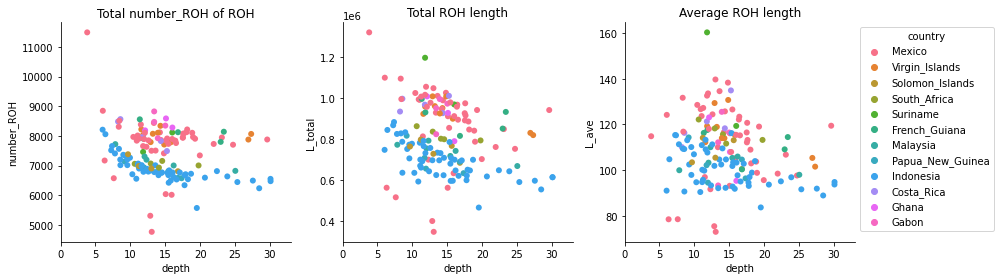

In [18]:
fig, axes = plt.subplots(1, 3, figsize = (14, 4))
# sns.set_palette(pal)

q = 20
round_q = 'from_Lisa_window_{}'.format(q)
values = ['number_ROH', 'L_total', 'L_ave']

for i in range(3):
    dfi = df_all_roh[df_all_roh['round'] == round_q]
    axi = axes[i]
    v = values[i]
    
    sns.scatterplot(ax=axi, data=dfi, x='depth', y=v, hue='country', linewidth=0)
    axi.set(xlim=(0, 33))
    
    if i == 0:
        axi.set_title('Total {} of ROH'.format(v))
    elif i == 1:
        axi.set_title('Total ROH length')
    else:
        axi.set_title('Average ROH length')
    if i != 2:
        axi.get_legend().set_visible(False)
    else:
        sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### 3.1.2. Plot binned ROH for different sliding window sizes: Mexico samples
### relative ROH across samples stays consistent except for the same outlier: dc_11121_bb_noq

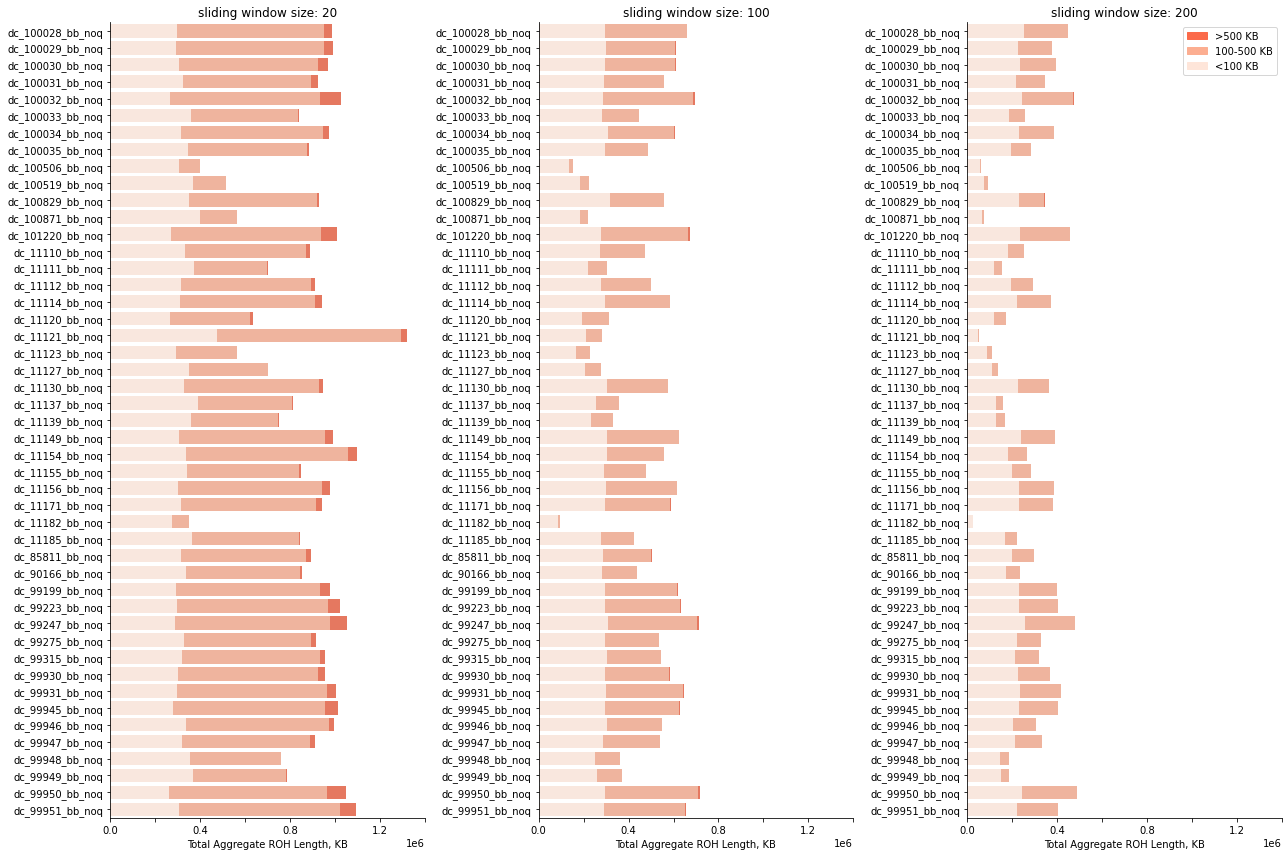

In [31]:
q_values = [20, 100, 200]
p = sns.color_palette(['#fee5d9', '#fcae91', '#fb6a4a', '#cb181d'])

fig, axes = plt.subplots(1, 3, figsize = (18, 12))

for i in range(3):
    axi = axes[i]
    q = q_values[i]
    round_q = 'from_Lisa_window_{}'.format(q)
    dfi = df_all_roh[(df_all_roh['round'] == round_q) & (df_all_roh['country'] == 'Mexico')]
    
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_total', color=p[2])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less500', color=p[1])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less100', color=p[0])
    
    axi.set(title='sliding window size: {}'.format(q), 
            xlabel='Total Aggregate ROH Length, KB',
            ylabel='', 
            xlim=(0, 1_400_000))
    
    labels = axi.get_xticklabels()
    for x, label in enumerate(labels):
        if x % 2 == 1:
            label.set_visible(False)

            
# add custom legend
bin1 = mpatches.Patch(color=p[2], label='>500 KB')
bin2 = mpatches.Patch(color=p[1], label='100-500 KB')
bin3 = mpatches.Patch(color=p[0], label='<100 KB')
plt.legend(handles=[bin1, bin2, bin3], loc="upper right")

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### 3.1.3. Plot binned ROH for 3 rounds running PLINK: Mexico samples

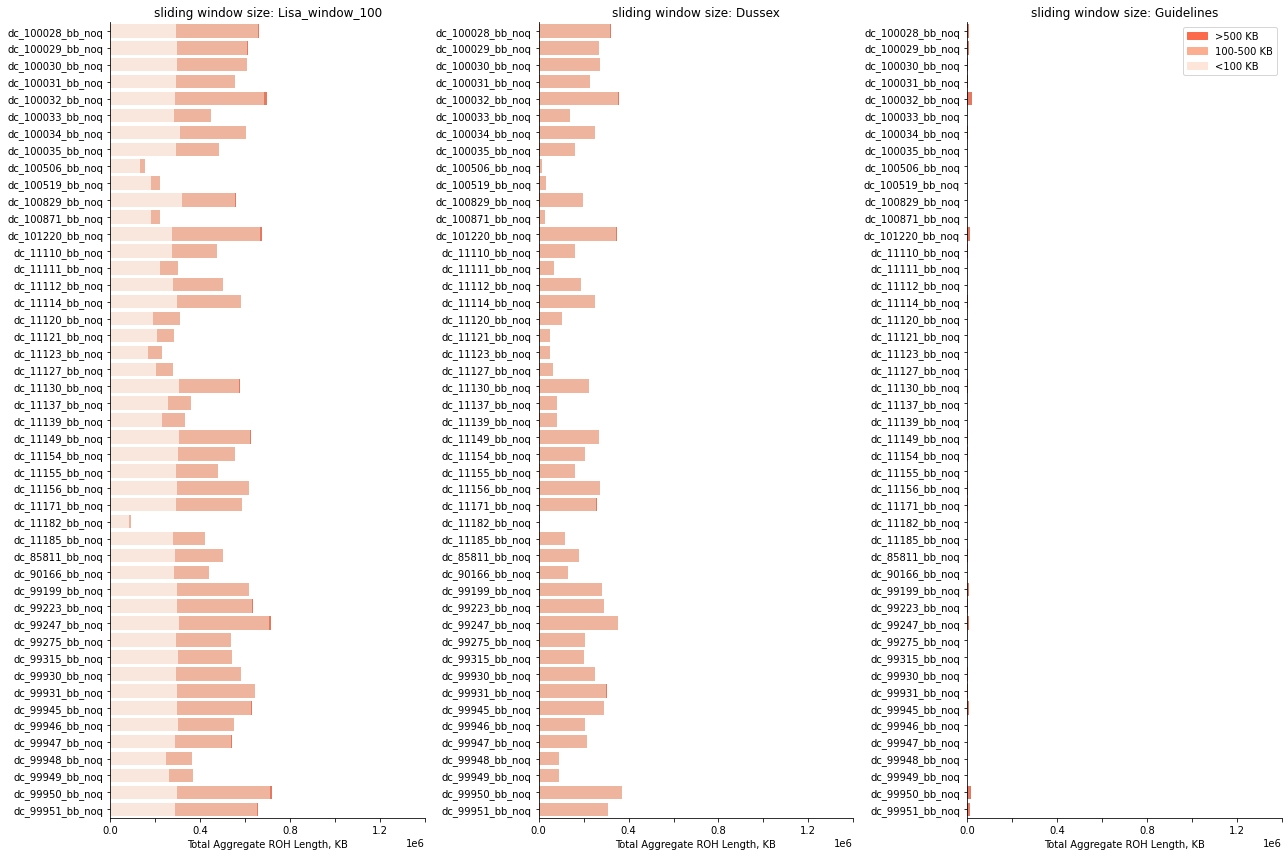

In [32]:
q_values = ['Lisa_window_100', 'Dussex', 'Guidelines']
p = sns.color_palette(['#fee5d9', '#fcae91', '#fb6a4a', '#cb181d'])

fig, axes = plt.subplots(1, 3, figsize = (18, 12))

for i in range(3):
    axi = axes[i]
    q = q_values[i]
    round_q = 'from_{}'.format(q)
    dfi = df_all_roh[(df_all_roh['round'] == round_q) & (df_all_roh['country'] == 'Mexico')]
    
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_total', color=p[2])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less500', color=p[1])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less100', color=p[0])
    
    axi.set(title='sliding window size: {}'.format(q), 
            xlabel='Total Aggregate ROH Length, KB',
            ylabel='', 
            xlim=(0, 1_400_000))
    
    labels = axi.get_xticklabels()
    for x, label in enumerate(labels):
        if x % 2 == 1:
            label.set_visible(False)
            
# add custom legend
bin1 = mpatches.Patch(color=p[2], label='>500 KB')
bin2 = mpatches.Patch(color=p[1], label='100-500 KB')
bin3 = mpatches.Patch(color=p[0], label='<100 KB')
plt.legend(handles=[bin1, bin2, bin3], loc="upper right")

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### 3.1.4 Calculate F_ROH (inbreeding coefficient) with PLINK and from_Lisa_window_20 parameters
### Plot number of homozygotes by impact as a function of inbreeding coefficient (F_ROH)

In [23]:
## Calculate F_ROH = L_ROH/Lgenome, in kb!!
L_genome = 2_164_762.090
df_all_roh['F_ROH'] = df_all_roh['L_total'] / L_genome

q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_roh = df_all_roh[df_all_roh['round'] == round_q][['sample', 'F_ROH', 'number_ROH']]
df_roh_merged = pd.merge(df_roh, df_all, on='sample')
df_roh_merged.head()

,sample,F_ROH,number_ROH,impact,state,number,variant,country,year,group,depth,fraction
0,dc_100028_bb_noq,0.456624,7863,HIGH,hom,104,snps,Mexico,2016,small_recovering,14.38,0.374101
1,dc_100028_bb_noq,0.456624,7863,HIGH,hom,2025,indels,Mexico,2016,small_recovering,14.38,0.816532
2,dc_100028_bb_noq,0.456624,7863,MODERATE,hom,2470,snps,Mexico,2016,small_recovering,14.38,0.358387
3,dc_100028_bb_noq,0.456624,7863,MODERATE,hom,223,indels,Mexico,2016,small_recovering,14.38,0.468487
4,dc_100028_bb_noq,0.456624,7863,LOW,hom,3595,snps,Mexico,2016,small_recovering,14.38,0.403978


### Consider only SNPs (exclude indels)

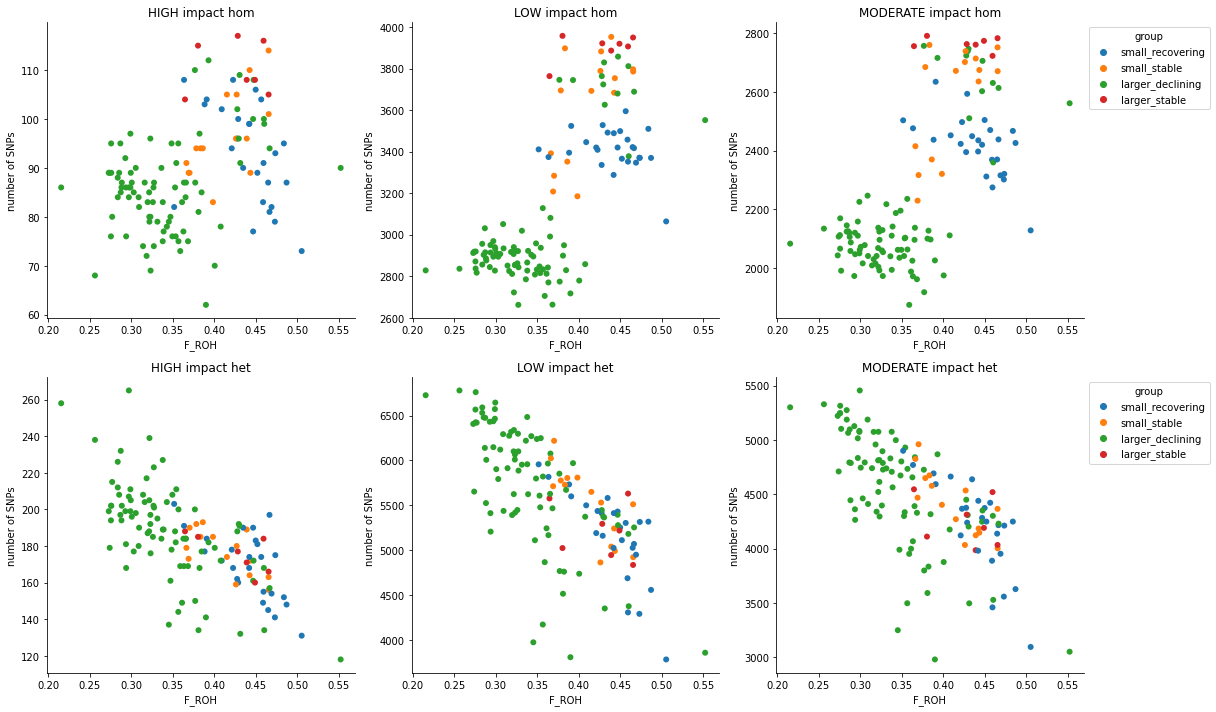

In [27]:
var = 'snps'
df_temp = df_roh_merged[(df_roh_merged['variant'] == var)]
df_temp = df_temp[df_temp['group'] != 'exclude']
# df_temp = df_roh_merged

states = list(set(df_temp['state']))
impacts = list(set(df_temp['impact']) - set(['MODIFIER']))

fig, axes = plt.subplots(2, 3, figsize = (17, 10))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        axi = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

#         sns.scatterplot(ax=axi, data=dfi, x='F_ROH', y='number', hue='country', linewidth=0)
        sns.scatterplot(ax=axi, data=dfi, x='F_ROH', y='number', hue='group', linewidth=0)
    #     axi.set(xlim=(-0.1, 1.1))
        axi.set_title('{} impact {}'.format(impact, state))
        axi.set_ylabel('number of SNPs')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### 3.1.5. Plot L_ROH = f(F_ROH)

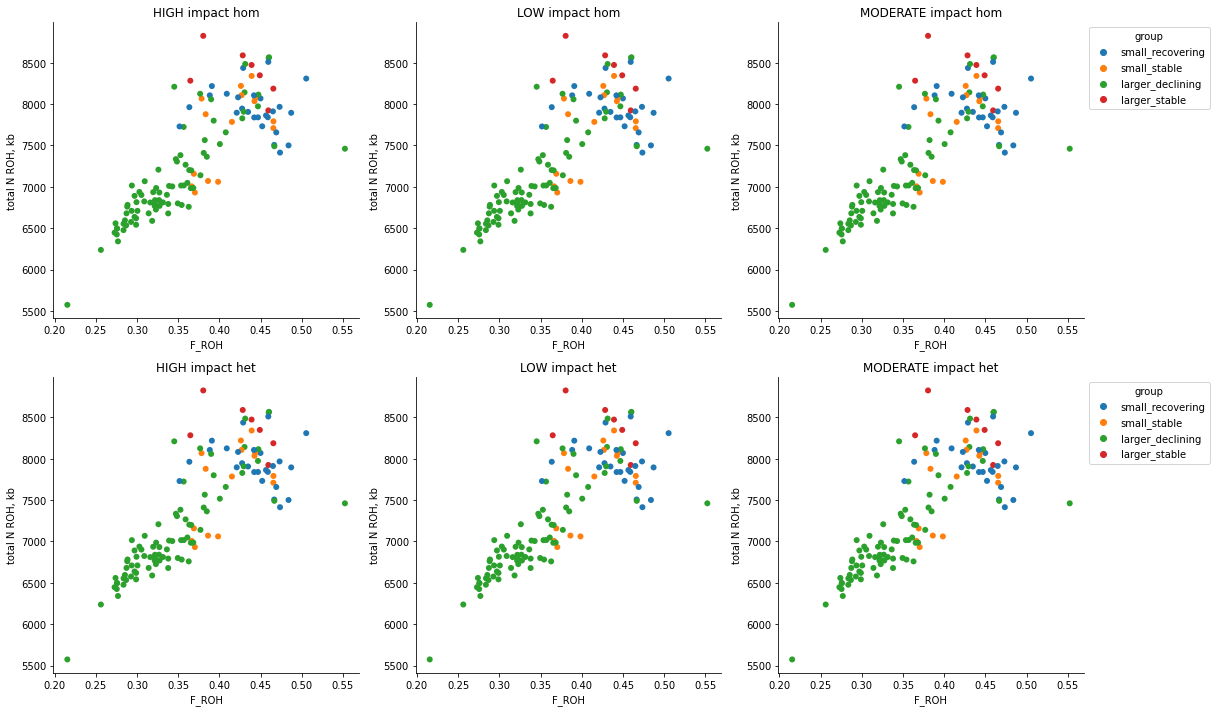

In [29]:
var = 'snps'
# df_temp = df_roh_merged[(df_roh_merged['variant'] == var)]

states = list(set(df_temp['state']))
impacts = list(set(df_temp['impact']) - set(['MODIFIER']))

fig, axes = plt.subplots(2, 3, figsize = (17, 10))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        axi = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

#         sns.scatterplot(ax=axi, data=dfi, x='F_ROH', y='number_ROH', hue='country', linewidth=0)
        sns.scatterplot(ax=axi, data=dfi, x='F_ROH', y='number_ROH', hue='group', linewidth=0)
    #     axi.set(xlim=(-0.1, 1.1))
        axi.set_title('{} impact {}'.format(impact, state))
        
        axi.set_ylabel('total N ROH, kb')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

In [30]:
df_roh_merged.head(3)

,sample,F_ROH,number_ROH,impact,state,number,variant,country,year,group,depth,fraction
0,dc_100028_bb_noq,0.456624,7863,HIGH,hom,104,snps,Mexico,2016,small_recovering,14.38,0.374101
1,dc_100028_bb_noq,0.456624,7863,HIGH,hom,2025,indels,Mexico,2016,small_recovering,14.38,0.816532
2,dc_100028_bb_noq,0.456624,7863,MODERATE,hom,2470,snps,Mexico,2016,small_recovering,14.38,0.358387


### 3.1.6. ROH = f(t) Mexico, Indonesia, and USVI

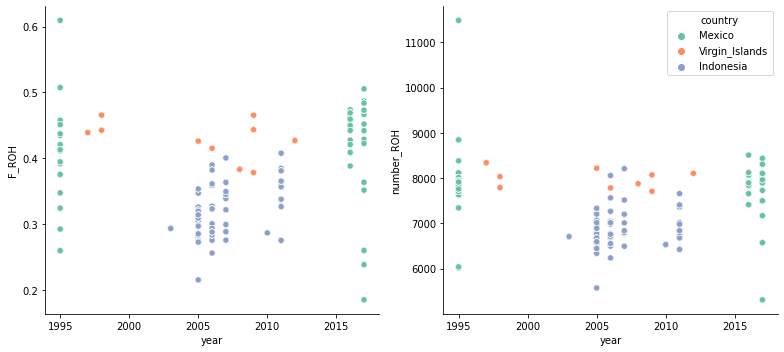

In [42]:
countries = ['Indonesia', 'Mexico', 'Virgin_Islands']
df_temporal = df_roh_merged[df_roh_merged['country'].isin(countries)].dropna()
df_temporal['year'] = pd.to_numeric(df_temporal['year'])

rohs = ['F_ROH', 'number_ROH']

sns.set_palette('Set2')
fig, axes = plt.subplots(1, 2, figsize = (11, 5))


for i in range(2):
    axi = axes[i]
    roh = rohs[i]

    dfi = df_temporal
#     sns.lineplot(ax=axi, data=dfi, x='year', y=roh, hue='country', marker='', ci=95)
    sns.scatterplot(ax=axi, data=dfi, x='year', y=roh, hue='country', markers=True)

#     axi.set_ylim(0, max(dfi['number']) + 400)
#     axi.set_title('{} impact variants in {}'.format(impact, state))
#     axi.set_ylabel('number of variants')
    if i == 0:
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 3.2. ROH analysis with bcftools

In [18]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'ROH_out/all_samples.L_ROH.tsv'
file_data = glob(dir_path + file_name)[0]
df_roh = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all_roh = pd.merge(df_roh, df_all, on='sample')

## Calculate F_ROH = L_ROH/Lgenome
L_genome = 2_164_762_090
df_all_roh['F_ROH'] = df_all_roh['L_ROH'] / L_genome
df_all_roh.head(3)

,sample,L_ROH,impact,state,number,variant,country,year,depth,F_ROH
0,dc_100028_bb_noq,387994397,HIGH,hom,104,snps,Mexico,2016,14.38,0.179232
1,dc_100028_bb_noq,387994397,HIGH,hom,2025,indels,Mexico,2016,14.38,0.179232
2,dc_100028_bb_noq,387994397,MODERATE,hom,2470,snps,Mexico,2016,14.38,0.179232


### 3.2.1. Merge bcftools and PLINK F_ROH results

In [23]:
df_ROH_bcftools_plink = pd.merge(df_roh_merged, df_all_roh[['sample', 'F_ROH']], on='sample')
df_ROH_bcftools_plink.rename({'F_ROH_x': 'F_ROH_plink', 'F_ROH_y': 'F_ROH_bcftools'}, axis='columns', inplace=True)
df_ROH_bcftools_plink.head(3)

,sample,F_ROH_plink,impact,state,number,variant,country,year,depth,F_ROH_bcftools
0,dc_100028_bb_noq,0.456624,HIGH,hom,104,snps,Mexico,2016,14.38,0.179232
1,dc_100028_bb_noq,0.456624,HIGH,hom,104,snps,Mexico,2016,14.38,0.179232
2,dc_100028_bb_noq,0.456624,HIGH,hom,104,snps,Mexico,2016,14.38,0.179232


### 3.2.2. Plot number of homozygotes by impact as a function of inbreeding coefficient (F_ROH)
### again, SNPs only, excluding indels

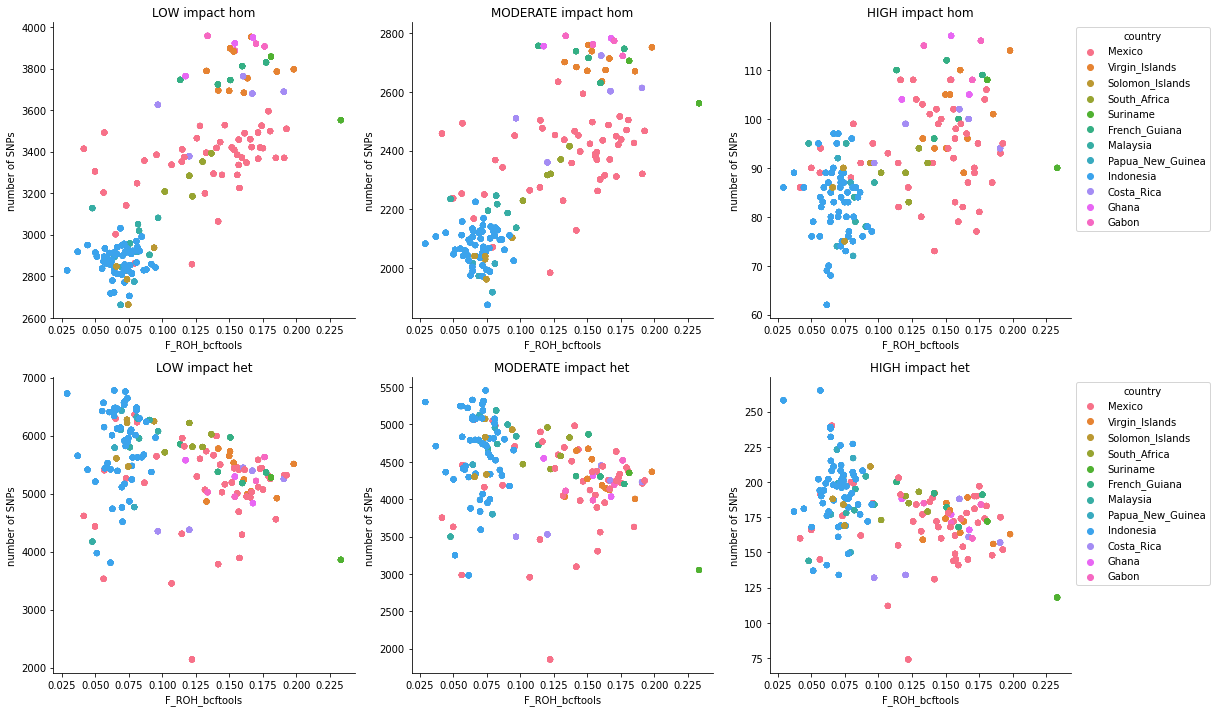

In [24]:
var = 'snps'
df_temp = df_ROH_bcftools_plink[(df_ROH_bcftools_plink['variant'] == var)]

states = list(set(df_temp['state']))
impacts = list(set(df_temp['impact']) - set(['MODIFIER']))

fig, axes = plt.subplots(2, 3, figsize = (17, 10))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        axi = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

        sns.scatterplot(ax=axi, data=dfi, x='F_ROH_bcftools', y='number', hue='country', linewidth=0)
    #     axi.set(xlim=(-0.1, 1.1))
        axi.set_title('{} impact {}'.format(impact, state))
        axi.set_ylabel('number of SNPs')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 3.3. Compare PLINK and bcftools F_ROH
### => high correlation, except for depth outliers

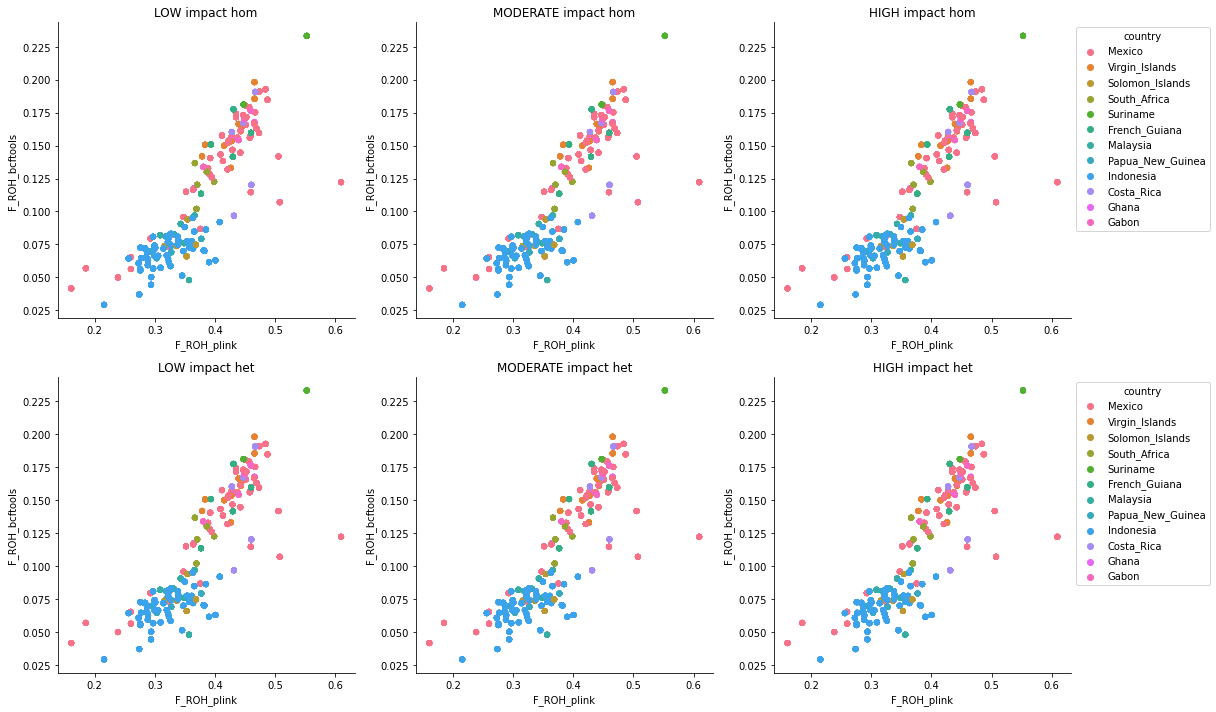

In [30]:
var = 'snps'
df_temp = df_ROH_bcftools_plink[(df_ROH_bcftools_plink['variant'] == var)]

states = list(set(df_temp['state']))
impacts = list(set(df_temp['impact']) - set(['MODIFIER']))

fig, axes = plt.subplots(2, 3, figsize = (17, 10))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        axi = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

        sns.scatterplot(ax=axi, data=dfi, x='F_ROH_plink', y='F_ROH_bcftools', hue='country', linewidth=0)
#         axi.set(xlim=(0, 1), ylim=(0, 0.5))
        axi.set_title('{} impact {}'.format(impact, state))
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()